In [3]:
from rdkit import Chem
import pickle
import numpy as np
import pandas as pd
from IPython import display

%%time
## for saving dataset as pickle
from deepchem.molnet import load_uspto

tasks, dataset, transformers = load_uspto(featurizer="plain")

dataset = dataset[0]

dataset = list(map(lambda x: x.split(">"), dataset.X))

import numpy as np

dataset = np.array(dataset)

pickle.dump({"reactants": dataset[:, 0], "reagents": dataset[:, 1], "products": dataset[:, 2]}, open("/home/abhor/Desktop/datasets/my_uspto/dataset", 'wb'))

In [32]:
dataset = pickle.load(open("/home/abhor/Desktop/datasets/my_uspto/dataset", 'rb'))

In [33]:
dataset = pd.DataFrame(dataset)

dataset["reactants"].shape

(479035,)

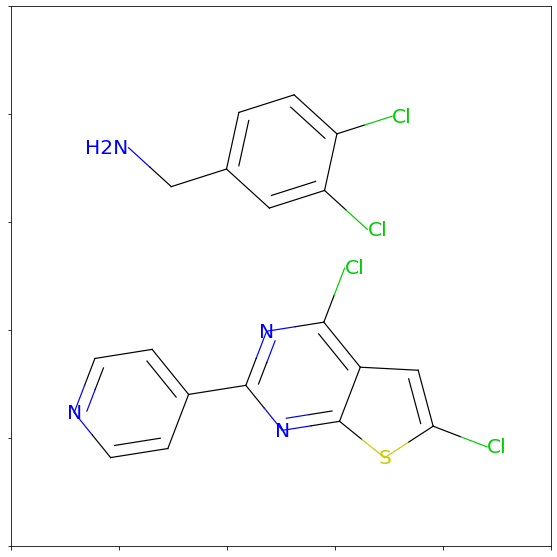

In [34]:
mol = Chem.MolFromSmiles(dataset["reactants"][4])

Chem.Draw.MolToMPL(mol)
pass

# Preprocessing - Products

In [35]:
%%time
print("Dataset shape to start with:", dataset.shape)

# first preprocess products
products = dataset["products"].tolist()
products = list(map(lambda x: x.split("."), products))

# remove small products
for i in range(len(products)):
    products[i] = list(filter(lambda x: len(x) > 6, products[i]))
dataset["products"] = products
print("Internally removed small products.", dataset.shape)

# add helper column with number of products
num_prod = list(map(len, products))
dataset["num_prod"] = num_prod
print("Added helper column with number of products.", dataset.shape)

# remove reactions that are left with no products
dataset = dataset[dataset["num_prod"] != 0]
print("Removed reactions with no products:", dataset.shape)

# divide reactions with more than 1 product
temp_df = dataset[dataset["num_prod"] != 1]
dataset = dataset[dataset["num_prod"] == 1]
dataset.reset_index(inplace=True)

for r in range(temp_df.shape[0]):
    row = temp_df.iloc[r]
    for product in row["products"]:
        new_row = row.copy()
        new_row["products"] = product
        dataset.loc[dataset.shape[0]+1] = new_row
if "index" in dataset.columns:
    dataset.drop(columns=["index"], inplace=True)
print("Divided reactions with multiple products :", dataset.shape)

# remove helper column
dataset.drop(columns=["num_prod"], inplace=True)
print("Removed helper column", dataset.shape)

# Some are still lists, make them strings again
dataset["products"] = dataset["products"].apply(lambda x: x[0] if isinstance(x, list) else x)

Dataset shape to start with: (479035, 3)
Internally removed small products. (479035, 3)
Added helper column with number of products. (479035, 4)
Removed reactions with no products: (478228, 4)
Divided reactions with multiple products : (478773, 4)
Removed helper column (478773, 3)
CPU times: user 30 s, sys: 2.23 s, total: 32.2 s
Wall time: 32.1 s


# Match the product with a reactant with the closest molecular weight

In [42]:
from rdkit.Chem.Descriptors import ExactMolWt

def mol_weight(smile):
    return ExactMolWt(Chem.MolFromSmiles(smile))

def matching_reactant(reactants, product):
    '''
    Takes a smile string of reactants and a single product.
    Returns the reactant which has the closest molecular weight to the product
    '''
    reactants = reactants.split(".")
    rmw = np.array(list(map(mol_weight, reactants)))
    pmw = mol_weight(product)
    return reactants[np.abs(rmw-pmw).argmin()]
    

In [75]:
%%time
dataset["reactants"] = dataset.apply(lambda row: matching_reactant(row["reactants"], row["products"]), axis=1)
print("Dataset after 1 to 1 mapping completed", dataset.shape)

Dataset after 1 to 1 mapping completed (448313, 3)
CPU times: user 575 µs, sys: 28 µs, total: 603 µs
Wall time: 408 µs


# Remove duplicates of reactant -> product and reactant -> reactant

In [73]:
dataset = dataset.drop_duplicates(subset=set(["reactants", "products"]),
                                 keep="first",
                                 ignore_index=True)
print("After removing duplicates:", dataset.shape)

After removing duplicates: (448509, 3)


In [74]:
# remove reactant = product
dataset = dataset.loc[(dataset["reactants"] != dataset["products"])]
print("After removing reactant = product", dataset.shape)

After removing reactant = product (448313, 3)


# Save the final thing

In [76]:
dataset

,reactants,reagents,products
0,CON(C)C(=O)c1ccc(O)nc1,C1CCOC1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1
1,O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,O,CNc1ccc(C(=O)O)cc1[N+](=O)[O-]
2,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21,,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21
3,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)O)c1,CC(C)=C(Cl)N(C)C.ClCCl.c1ccncc1,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...
4,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1,,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1
...,...,...,...
448504,CCP(CC)CC,,CCCCOS(=O)(=O)[O-]
448505,CCCCOS(=O)(=O)OCCCC,,CCCC[P+](CC)(CC)CC
448506,Cc1cccc(C)c1N=C1NCCN1OCc1ccccn1,CC#N.Cl,Cc1cccc(C)c1N=C1NCCN1O
448507,Clc1ccnc(Cl)c1,ClCCl,N[n+]1ccc(Cl)cc1Cl


In [77]:
dataset.to_csv("/home/abhor/Desktop/datasets/my_uspto/processed_data.csv")

# Graph - find reaction sequences

create adjacency list for Y -> X for same smile string

In [78]:
# generate sequences
# too slow on single core and multicore is problematic on notebook - so running as a separate python script
! python generate_sequences.py

1640it [00:00, 1955.09it/s]                                                     


In [4]:
reaction_sequences = pickle.load(open("/home/abhor/Desktop/datasets/my_uspto/intermediate_sequences.pickle", 'rb'))

In [5]:
temp = []
while reaction_sequences:
    temp.extend(reaction_sequences.pop(0))
reaction_sequences = temp

In [6]:
len(reaction_sequences)

453372

In [7]:
temp = list(map(len, reaction_sequences))

pd.value_counts(temp)

2     188216
3      80423
4      45852
5      31581
6      22576
7      18141
8      15327
9      13207
10     11380
11      9352
12      6752
13      4098
14      2377
15      1345
16       777
17       458
18       373
19       303
21       241
20       225
22       216
23       121
24        31
dtype: int64

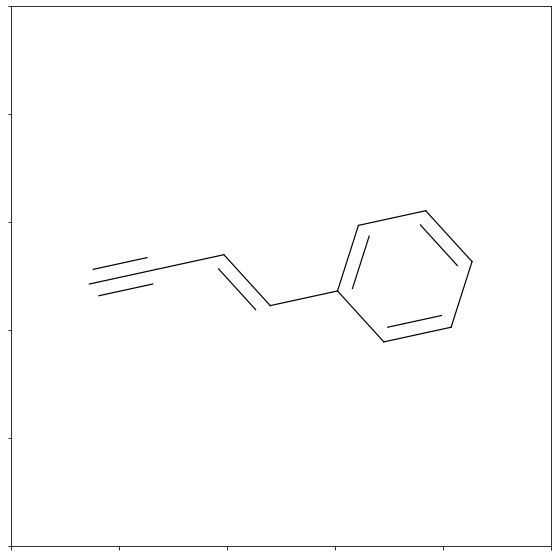

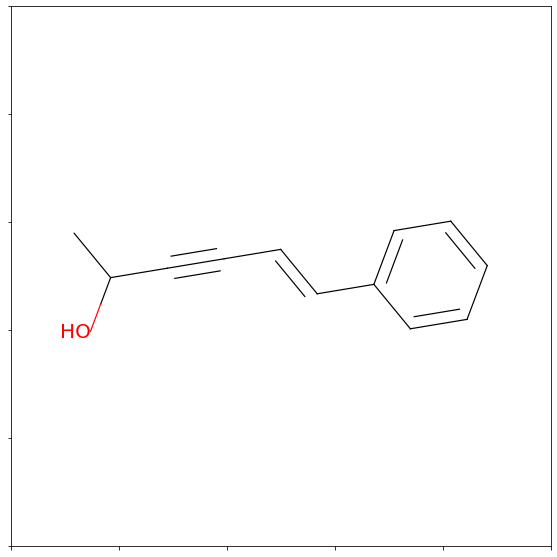

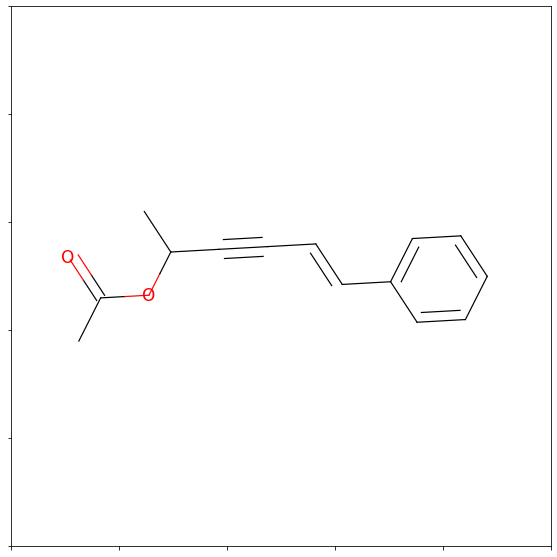

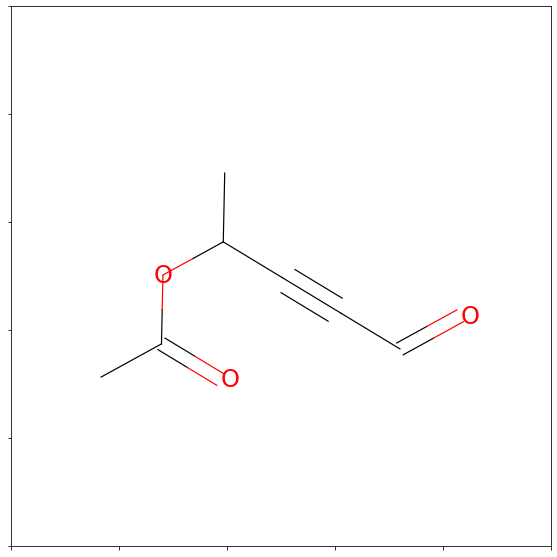

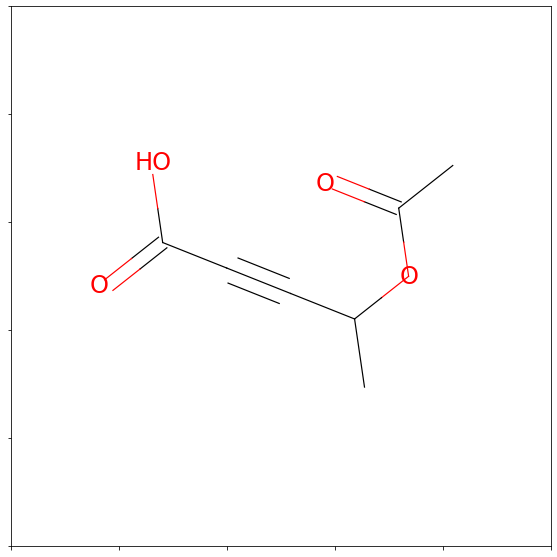

In [8]:
# an example reaction sequence
subseq = np.array(list(filter(lambda x: len(x) == 5, reaction_sequences)))

for smile in subseq[1]:
    mol = Chem.MolFromSmiles(smile)
    Chem.Draw.MolToMPL(mol)
    pass